Topic: discriminative classification

In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [60]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math
import seaborn as sns

In [3]:
import h5py
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
list(f.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [4]:
d = {i: f[i][:] for i in f.keys()}
data = pd.DataFrame(data=d)
data

,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,det,iota,mtot,psi,q,ra,snr,z
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,0,1.809310,906.803562,1.286031,0.624780,-3.116784,0.822509,2.139659
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,0,0.820820,59.102112,0.934308,0.986650,1.360291,1.093237,2.438707
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,0,2.008206,44.602750,1.535520,0.286199,0.079973,1.305398,1.869461
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0,2.018398,534.378032,3.064086,0.538882,-1.780558,9.112974,0.428061
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,1,2.037363,573.821705,0.752211,0.846310,2.789289,17.525534,0.772609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999995,-0.192062,-0.132125,0.099840,0.244232,-0.610395,0.205643,0.227502,0,1.712124,47.173930,0.458902,0.721899,2.747641,0.550924,2.942686
19999996,-0.004265,-0.056190,-0.030455,0.080665,-0.263666,-0.028503,-0.289584,0,1.796748,319.515160,2.011788,0.276340,-3.010306,6.303695,1.348554
19999997,-0.558253,-0.107589,0.065246,0.305706,-0.212490,-0.412048,-0.236878,0,0.894741,536.491292,1.776291,0.909982,-1.638381,9.975289,0.826640
19999998,0.084775,-0.042762,0.017719,0.145657,0.474321,0.744677,0.104063,0,1.102068,879.055152,1.317251,0.287587,2.211932,0.920406,3.125594


Let's check if we have any 'nan' in the dataset.

In [5]:
for i in list(f.keys()):
    print(len(data[i][data[i]=='nan']))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


First, let's use only the first 5000 rows.

In [6]:
smaller_data = data[:5000]
print('Fraction on detectable binaries: '+str(len(smaller_data['det'][smaller_data['det']==1])/len(smaller_data['det'])))

Fraction on detectable binaries: 0.1456


Only $14\%$ of the binaries are labeled as detectable. The detectable binaries are "rare objects": we want to be sure to correctly identify all of them, so we want to maximise the completeness of our model, at the risk of a slightly higher contamination.

Let's split our dataset in test and train sets.

In [7]:
smaller_data = smaller_data.drop(['det', 'snr'],axis=1)
smaller_labels = data.det[:5000]

x_train, x_test, y_train, y_test = train_test_split(smaller_data, smaller_labels, train_size = 0.8, random_state=42)

# Decision tree

Let's optimize the parameter max_depth using cross-validation.

In [25]:
def cross_DT(d):
    model = DecisionTreeClassifier(max_depth=d)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    predictions = []
    for train, test in kf.split(x_train.to_numpy()):
        model.fit(x_train.to_numpy()[train],y_train.to_numpy()[train])
        y_pred = model.predict(x_train.to_numpy()[test])
        predictions.append(y_pred)
    completeness, contamination = completeness_contamination(predictions, y_train.to_numpy()[test])
    return np.mean(completeness), np.mean(contamination)

In [44]:
depth = np.arange(1,20,1)
completeness = []
contamination = []

for d in depth:
    comp, cont = cross_DT(d)
    completeness.append(comp)
    contamination.append(cont)

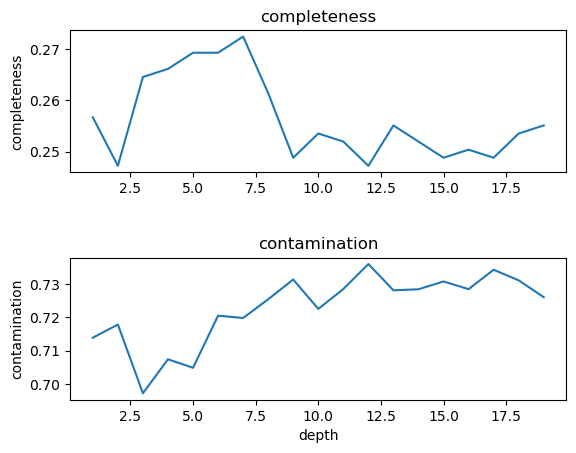

In [45]:
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.6)

axes[0].plot(depth,completeness)
axes[0].set_title('completeness')
axes[0].set_ylabel('completeness')

axes[1].plot(depth,contamination)
axes[1].set_title('contamination')
axes[1].set_ylabel('contamination')
axes[1].set_xlabel('depth')
plt.show()

In [46]:
best_DT = depth[completeness==np.max(completeness)][0]

In [47]:
model = DecisionTreeClassifier(max_depth=depth[completeness==np.max(completeness)][0])
model.fit(x_train.to_numpy(),y_train)
y_pred = model.predict(x_test.to_numpy())
completeness, contamination = completeness_contamination(y_pred, y_test.to_numpy())
print('Final evaluation on the test set:')
print('Completeness: '+str(completeness))
print('Contamination: '+str(contamination))
comp_DT = completeness

Final evaluation on the test set:
Completeness: 0.7619047619047619
Contamination: 0.19424460431654678


# Bagging

In [48]:
def cross_BG(d):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    predictions = []
    for train, test in kf.split(x_train.to_numpy()):
        model.fit(x_train.to_numpy()[train],y_train.to_numpy()[train])
        y_pred = model.predict(x_train.to_numpy()[test])
        predictions.append(y_pred)
    completeness, contamination = completeness_contamination(predictions, y_train.to_numpy()[test])
    return np.mean(completeness), np.mean(contamination)

In [49]:
depth = np.arange(1,20,1)
completeness = []
contamination = []

for d in depth:
    comp, cont = cross_BG(d)
    completeness.append(comp)
    contamination.append(cont)

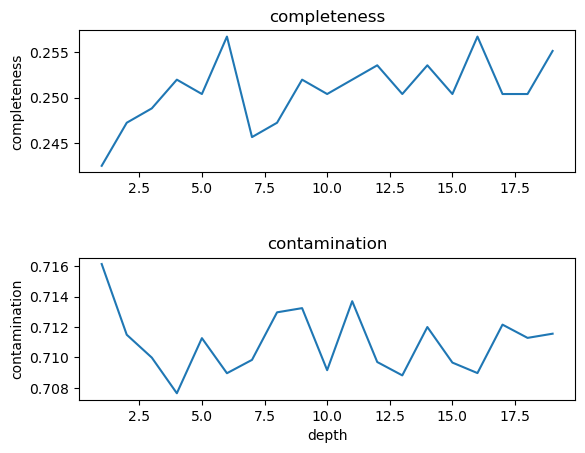

In [50]:
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.6)

axes[0].plot(depth,completeness)
axes[0].set_title('completeness')
axes[0].set_ylabel('completeness')

axes[1].plot(depth,contamination)
axes[1].set_title('contamination')
axes[1].set_ylabel('contamination')
axes[1].set_xlabel('depth')
plt.show()

In [51]:
best_bag = depth[completeness==np.max(completeness)][0]

In [52]:
model = BaggingClassifier(DecisionTreeClassifier(max_depth=depth[completeness==np.max(completeness)][0]), 
                          n_estimators=500, max_samples=100, 
                          bootstrap=True, n_jobs=-1)
model.fit(x_train.to_numpy(),y_train)
y_pred = model.predict(x_test.to_numpy())
completeness, contamination = completeness_contamination(y_pred, y_test.to_numpy())
print('Final evaluation on the test set:')
print('Completeness: '+str(completeness))
print('Contamination: '+str(contamination))
comp_bag = completeness

Final evaluation on the test set:
Completeness: 0.7346938775510204
Contamination: 0.20588235294117646


Bagging does worst (+bigger computational cost!)

# Random forest

In [53]:
def cross_RF(d):
    model = RandomForestClassifier(max_depth=d)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    predictions = []
    for train, test in kf.split(x_train.to_numpy()):
        model.fit(x_train.to_numpy()[train],y_train.to_numpy()[train])
        y_pred = model.predict(x_train.to_numpy()[test])
        predictions.append(y_pred)
    completeness, contamination = completeness_contamination(predictions, y_train.to_numpy()[test])
    return np.mean(completeness), np.mean(contamination)

In [54]:
depth = np.arange(1,20,1)
completeness = []
contamination = []

for d in depth:
    comp, cont = cross_RF(d)
    completeness.append(comp)
    contamination.append(cont)

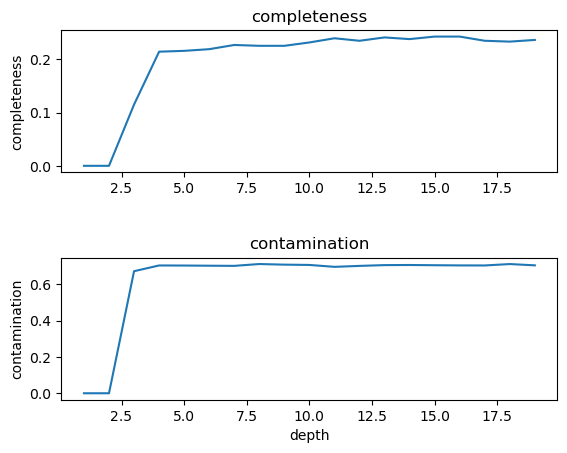

In [55]:
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.6)

axes[0].plot(depth,completeness)
axes[0].set_title('completeness')
axes[0].set_ylabel('completeness')

axes[1].plot(depth,contamination)
axes[1].set_title('contamination')
axes[1].set_ylabel('contamination')
axes[1].set_xlabel('depth')
plt.show()

In [56]:
best_RF = depth[completeness==np.max(completeness)][0]

In [57]:
model = RandomForestClassifier(max_depth=depth[completeness==np.max(completeness)][0])
model.fit(x_train.to_numpy(),y_train)
y_pred = model.predict(x_test.to_numpy())
completeness, contamination = completeness_contamination(y_pred, y_test.to_numpy())
print('Final evaluation on the test set:')
print('Completeness: '+str(completeness))
print('Contamination: '+str(contamination))
comp_RF = completeness

Final evaluation on the test set:
Completeness: 0.7278911564625851
Contamination: 0.12295081967213115


# ROC curve

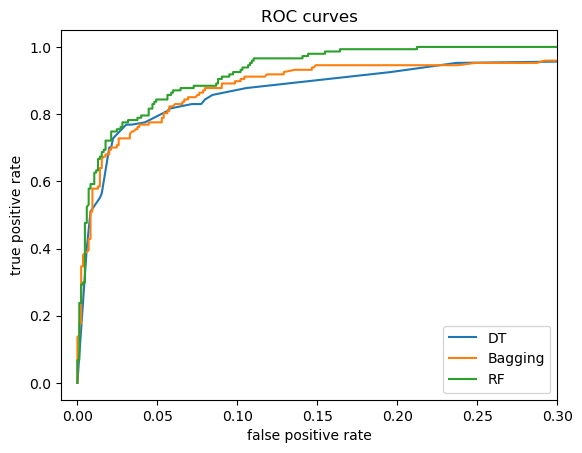

In [58]:
dtree = DecisionTreeClassifier(max_depth=best_DT)
dtree.fit(x_train.to_numpy(),y_train)
scores = dtree.predict_proba(x_test.to_numpy())[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
plt.plot(fpr,tpr,label= 'DT')

bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=best_bag), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, n_jobs=-1)
bag_clf.fit(x_train.to_numpy(),y_train)
scores = bag_clf.predict_proba(x_test.to_numpy())[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
plt.plot(fpr,tpr,label= 'Bagging')

ranfor = RandomForestClassifier(max_depth=best_RF)
ranfor.fit(x_train.to_numpy(),y_train)
scores = ranfor.predict_proba(x_test.to_numpy())[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
plt.plot(fpr,tpr,label= 'RF')

plt.xlim(-0.01,0.3)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curves')
plt.legend()
plt.show()

In [59]:
print('Completeness')
print('DT: ', comp_DT)
print('Bagging: ', comp_bag)
print('RF: ', comp_RF)

Completeness
DT:  0.7619047619047619
Bagging:  0.7346938775510204
RF:  0.7278911564625851
